In [1]:
# general libraries
import pandas as pd
import pandas.testing as tm
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import re
import seaborn as sns
from IPython.display import IFrame

# network analysis
import networkx as nx
from networkx.algorithms import bipartite

# text analysis
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# formatting commands
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1.5)

/Users/dpong/.local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def component_size_one(G):
    '''Take a graph G and return a list of the 
       connected components of size 1 and the
       number of connected components of size 1'''
    components = [list(G) for G in nx.connected_components(G) if len(G) == 1]
    num_components = len(components)
    return components, num_components

# function to get large graph components
def giant_component_size(G):
    '''Take a graph G and return the largest connected component, 
        a list of the connected components > 1 and 
        the number of connected components > 1'''
    components = [(len(G), list(G)) for G in nx.connected_components(G) if len(G) > 1]
    num_components = len(components)
    GCC = [y[1] for y in components if y[0]
           == max([x[0] for x in components])][0]
    return GCC, components, num_components

# function to clean string
def clean_string(text):
    '''Take any text and return a cleaned version of the text
        without punctuation, lower cased, and removes stopwords'''
    text = ''.join([w for w in text if w not in string.punctuation])
    text = text.lower()
    text = ' '.join([w for w in text.split() if w not in stopwords])
    
    return text

# function to get the ngrams of a word or phrase
def ngrams(string, n=2):
    '''Takes any string removes characters, and creates
        ngrams of length n. Returns string and ngrams of
        string'''
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

# function to get the top n cosine similarity scores
def cos_sim_top(A, B, ntop, lower_bound=0):
    '''Takes any matrix A and B and returns the top n
        matching values with the higest cosine similarity
        score'''
    
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape
 
    idx_dtype = np.int32
 
    nnz_max = M*ntop
 
    indptr = np.zeros(M+1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)
    ct.sparse_dot_topn(
        M, N, np.asarray(A.indptr, dtype=idx_dtype),
        np.asarray(A.indices, dtype=idx_dtype),
        A.data,
        np.asarray(B.indptr, dtype=idx_dtype),
        np.asarray(B.indices, dtype=idx_dtype),
        B.data,
        ntop,
        lower_bound,
        indptr, indices, data)
    return csr_matrix((data,indices,indptr),shape=(M,N))

# function to return the names that were run through the cossim_top function
def get_matches_df(sparse_matrix, name_vector, top=None):
    '''Takes any sparse matrix constructed from a name vector
        and returns the names and scores of values in the sparse
        matrix with a defned % cut off'''
    
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_side = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    similairity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        left_side[index] = name_vector[sparserows[index]]
        right_side[index] = name_vector[sparsecols[index]]
        similairity[index] = sparse_matrix.data[index]
    
    return pd.DataFrame({'left_side': left_side,
                          'right_side': right_side,
                           'similarity': similairity})

In [6]:
# loading listing data

listing_df = pd.read_csv('listings_tokyo.csv',dtype=object)
listing_df.rename(columns={'id':'listing_id'},inplace=True)
listing_df.shape

(11197, 74)

In [7]:
listing_df.head()

,listing_id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20210327014458,2021-03-28,Oshiage Holiday Apartment,<b>The space</b><br />We are happy to welcome ...,NaN,https://a0.muscache.com/pictures/38437056/d27f...,964081,https://www.airbnb.com/users/show/964081,...,10,9,10,M130003350,f,1,1,0,0,1.42
1,776070,https://www.airbnb.com/rooms/776070,20210327014458,2021-03-28,Kero-kero house room 1,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,801494,https://www.airbnb.com/users/show/801494,...,10,10,10,M130000243,t,1,0,1,0,2.25
2,899003,https://www.airbnb.com/rooms/899003,20210327014458,2021-03-29,"Classy room @Shinjuku, Takadanoba",..*+;.*:' Popular room in Airbnb@Tokyo *;+:..*...,NaN,https://a0.muscache.com/pictures/20005274/1df3...,4799233,https://www.airbnb.com/users/show/4799233,...,9,9,9,Other reasons | 【マンスリー契約】最低30泊以上の一時使用賃貸借契約を結びま...,f,2,2,0,0,0.94
3,1016831,https://www.airbnb.com/rooms/1016831,20210327014458,2021-03-29,WOMAN ONLY LICENSED ! Cosy & Cat behnd Shibuya,female travellers here only.<br />Sorry no boy...,The location is walkable distance to famous Sh...,https://a0.muscache.com/pictures/20134416/5c34...,5596383,https://www.airbnb.com/users/show/5596383,...,10,10,10,M130001107,f,1,0,1,0,2.17
4,1033276,https://www.airbnb.com/rooms/1033276,20210327014458,2021-03-29,private room @Senju area,Our house is new and clean <br />Big hub stati...,There are shopping mall near Senjuohashi stati...,https://a0.muscache.com/pictures/71577415/b060...,5686404,https://www.airbnb.com/users/show/5686404,...,10,9,9,M130007760,f,2,0,2,0,0.75


In [8]:
# loading reviews data

reviews_df = pd.read_csv("reviews_tokyo.csv", dtype = object)
reviews_df.shape

(298133, 6)

In [9]:
# drop null comments from review data
reviews_df.dropna(inplace=True)
reviews_df.shape

(297912, 6)

In [10]:
# drop reviews containing 'This is an automated posting'
automated = reviews_df[reviews_df.comments.str.contains('This is an automated posting')].index
reviews_df.drop(index=automated, inplace=True)
reviews_df.shape

(297337, 6)

In [11]:
# reviews_df.listing_id.sort_values(ascending = True).unique()

In [12]:
# set up dataframes to merge
df_review = reviews_df[['listing_id', 'reviewer_id', 'reviewer_name', 'id', 'date', 'comments']].copy()
df_listing = listing_df[['listing_id', 'host_id', 'host_name']].copy()

# merge the dataframes
df_merged = pd.merge(df_review, df_listing, how='left', on='listing_id')
df_merged.shape

(297337, 8)

In [13]:
df_listing.shape

(11197, 3)

In [14]:
df_listing.head()

,listing_id,host_id,host_name
0,197677,964081,Yoshimi & Marek
1,776070,801494,Kei
2,899003,4799233,Yu
3,1016831,5596383,Wakana
4,1033276,5686404,NaN


In [15]:
df_merged[df_merged.listing_id == "1033276"]

,listing_id,reviewer_id,reviewer_name,id,date,comments,host_id,host_name
696,1033276,1570526,Lawrence,4411328,2013-05-03,"Great Place with private room, wifi, kitchen, ...",5686404,NaN
697,1033276,5944429,Tessa,4719969,2013-05-21,Sufficient comfortable space with the basic ne...,5686404,NaN
698,1033276,4370306,Yuki,5135309,2013-06-14,I booked this place for my daughter. Yukiko me...,5686404,NaN
699,1033276,6233032,Nelson,5276554,2013-06-22,Disclaimer: this house isn't ideal for someone...,5686404,NaN
700,1033276,2279081,Sol,5792779,2013-07-16,Quite comfortable for our short stay. Adachi ...,5686404,NaN
...,...,...,...,...,...,...,...,...
763,1033276,152605983,Jihee,250987558,2018-04-07,예상보다 짧은 기간 머물렀는데\n제가 입장권을 인쇄해오지 못해서 인쇄해주실 수 있냐...,5686404,NaN
764,1033276,40427764,Selina,253629689,2018-04-15,Yukiko-san was very accommodating and met me a...,5686404,NaN
765,1033276,181274400,Joo,258874559,2018-04-30,하네다 공항으로 오가는 공항버스가 집과 5분거리린 센주오하시역에 있어 편하게 오갔으...,5686404,NaN
766,1033276,33416278,Chloe,263824270,2018-05-13,Le logement et la chambre sont simples. Un peu...,5686404,NaN


In [16]:
# clean the merged dataframe
df_merged.dropna(inplace=True)
df_merged.drop_duplicates(subset=['id'], inplace=True)
df_merged.comments = df_merged.comments.map(lambda x: x.replace('\r', ''))
df_merged.reviewer_id = df_merged.reviewer_id.astype(int)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285985 entries, 0 to 297336
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     285985 non-null  object
 1   reviewer_id    285985 non-null  int64 
 2   reviewer_name  285985 non-null  object
 3   id             285985 non-null  object
 4   date           285985 non-null  object
 5   comments       285985 non-null  object
 6   host_id        285985 non-null  object
 7   host_name      285985 non-null  object
dtypes: int64(1), object(7)
memory usage: 19.6+ MB


In [17]:
# calculate the number of reviews per hosts
host_review_counts = df_merged.groupby('host_id')[['id']].nunique().reset_index()
host_review_counts.rename(columns={'id': 'host_review_count'}, inplace=True)

# calculate reviews per reviewer
reviewer_review_counts = df_merged.groupby('reviewer_id')[['id']].nunique().reset_index()
reviewer_review_counts.rename(columns={'id': 'reviewer_review_count'}, inplace=True)

# calculate number of listings by host
host_listing_counts = df_merged.groupby('host_id')[['listing_id']].nunique().reset_index()
host_listing_counts.rename(columns={'listing_id': 'host_listing_counts'}, inplace=True)

# calculate number of hosts reviewed by reviewers
reviewer_host_counts = df_merged.groupby(['reviewer_id'])[['host_id']].nunique().reset_index()
reviewer_host_counts.rename(columns={'host_id': 'reviewer_host_counts'}, inplace=True)

In [18]:
df_merged_final = pd.merge(df_merged, host_review_counts, how='left', on='host_id')
df_merged_final = pd.merge(df_merged_final, reviewer_review_counts, how='left', on='reviewer_id')
df_merged_final = pd.merge(df_merged_final, host_listing_counts, how='left', on='host_id')
df_merged_final = pd.merge(df_merged_final, reviewer_host_counts, how='left', on='reviewer_id')
df_merged_final.shape

(285985, 12)

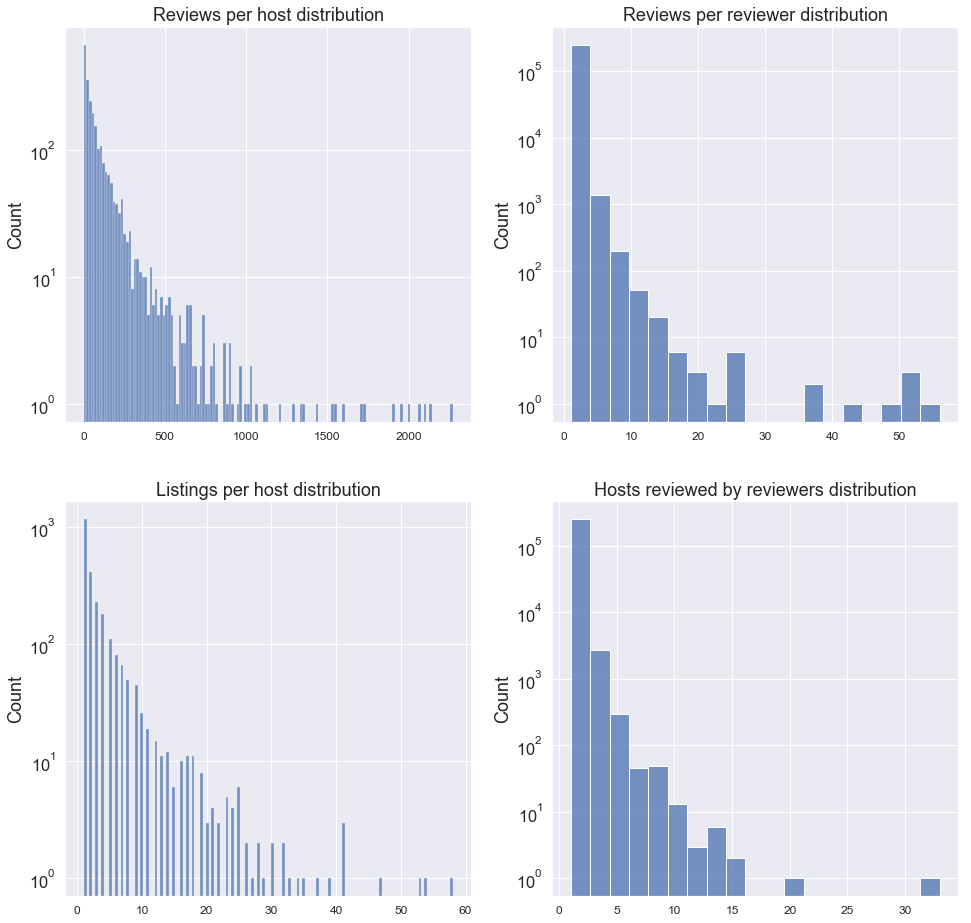

In [19]:
# plot histograms of host counts and reviewer counts
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(16, 16))
sns.histplot(host_review_counts.host_review_count, ax=ax[0,0])
sns.histplot(reviewer_review_counts.reviewer_review_count, ax=ax[0,1])
sns.histplot(host_listing_counts.host_listing_counts, ax=ax[1,0])
sns.histplot(reviewer_host_counts.reviewer_host_counts, ax=ax[1,1])
ax[0,0].set_title('Reviews per host distribution')
ax[0,1].set_title('Reviews per reviewer distribution')
ax[1,0].set_title('Listings per host distribution')
ax[1,1].set_title('Hosts reviewed by reviewers distribution')

for a in ax.flatten():
    a.set_xlabel('')
    a.tick_params(axis='x', labelsize=12, labelrotation=0)
    a.set_yscale('log')

plt.show()

In [20]:
subset = df_merged_final[df_merged_final.duplicated(subset=['host_id', 'reviewer_id'], keep=False)].copy()
subset = subset[subset.host_listing_counts >= 5]
subset = subset[subset.reviewer_host_counts > 2]
subset.drop_duplicates(subset=['host_id', 'reviewer_id', 'listing_id', 'date'], keep=False, inplace=True)
subset.shape

(1391, 12)

In [21]:
subset = df_merged_final[df_merged_final.duplicated(subset=['host_id', 'reviewer_id'], keep = False)].copy()
subset = subset[subset.host_listing_counts >= 5]
subset = subset[subset.reviewer_host_counts > 2]
subset.drop_duplicates(subset=['host_id', 'reviewer_id', 'listing_id', 'date'], inplace=True)
subset.shape

(1394, 12)

In [22]:
print('Number of reviewers: ', len(subset.reviewer_id.unique()))
print('Number of hosts: ', len(subset.host_id.unique()))

Number of reviewers:  425
Number of hosts:  214


In [23]:
hosts = dict(subset[['host_id', 'host_name']].values)
reviewers = dict(subset[['reviewer_id', 'reviewer_name']].values)
labels_dict = {**reviewers, **hosts}

### Initial 2-Mode Network

In [24]:
subset.reviewer_id.nunique()

425

In [25]:
subset.host_id.nunique()

214

In [26]:
G = nx.Graph()
# Use bipartite 0 or 1 to denote which node it belongs to
G.add_nodes_from(subset.reviewer_id.unique(), bipartite=0)
G.add_nodes_from(subset.host_id.unique(), bipartite=1)
G.add_edges_from(subset[['reviewer_id', 'host_id']].values)

In [27]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 639
Number of edges: 532
Average degree:   1.6651


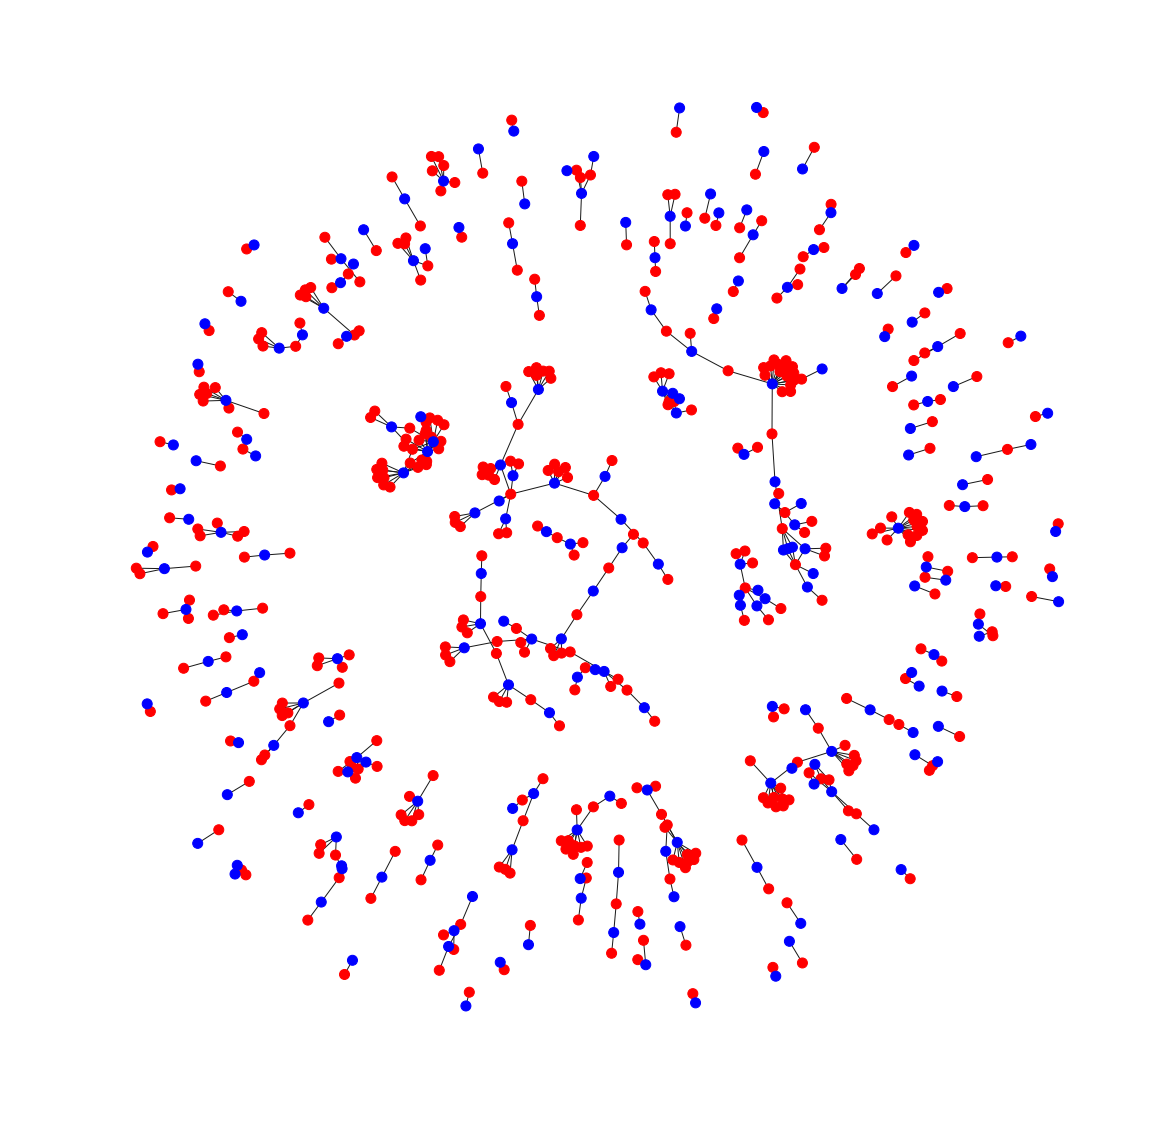

In [28]:
# nodes
reviewer_nodes = subset.reviewer_id.unique().tolist()
host_nodes = subset.host_id.unique().tolist()

# create plot
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G,iterations=35)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=['red']*len(reviewer_nodes) +
        ['blue']*(len(host_nodes)))
nx.draw_networkx_edges(G, pos, width=1)
plt.axis("off")
plt.show()

### Bipartite host graph

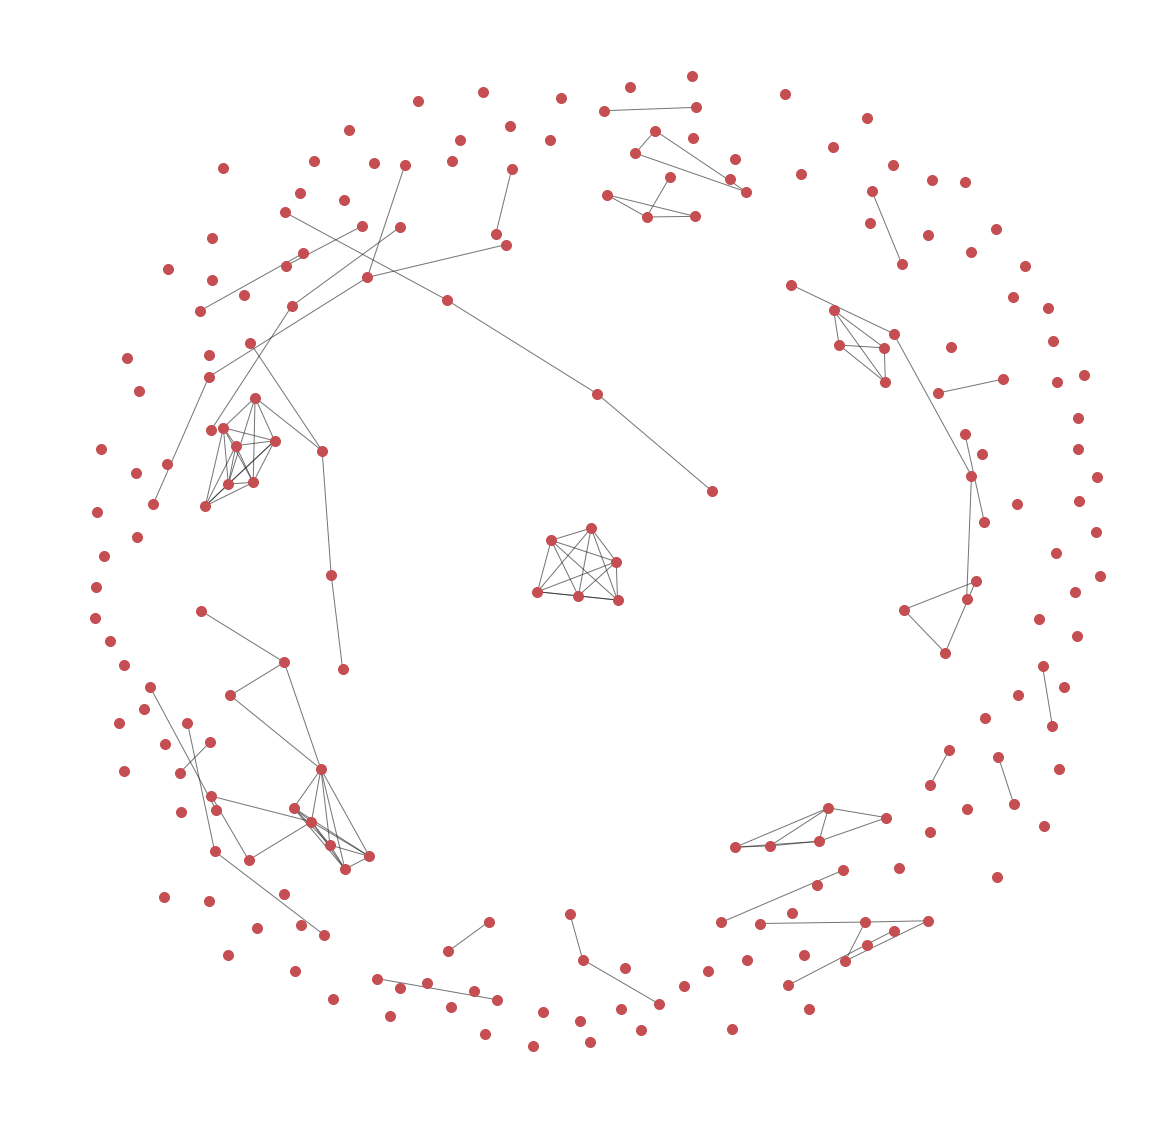

In [29]:
# look at projected graph (on hosts)
host_nodes = subset.host_id.unique().tolist()
B = bipartite.projected_graph(G, host_nodes)

pos = nx.spring_layout(B,iterations=15)
labels = {node: labels_dict[node] for node in B.nodes()}

# create plot
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(B, pos, node_size=100)
nx.draw_networkx_edges(B, pos, width=1,alpha=0.6)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=10, font_family="sans-serif")
plt.axis("off")
plt.show()

In [30]:
# identify the components with no links
components_one, n_one = component_size_one(B)
components_one = [item for sublist in components_one for item in sublist]

print("Number of components:\n", n_one)

Number of components:
 109


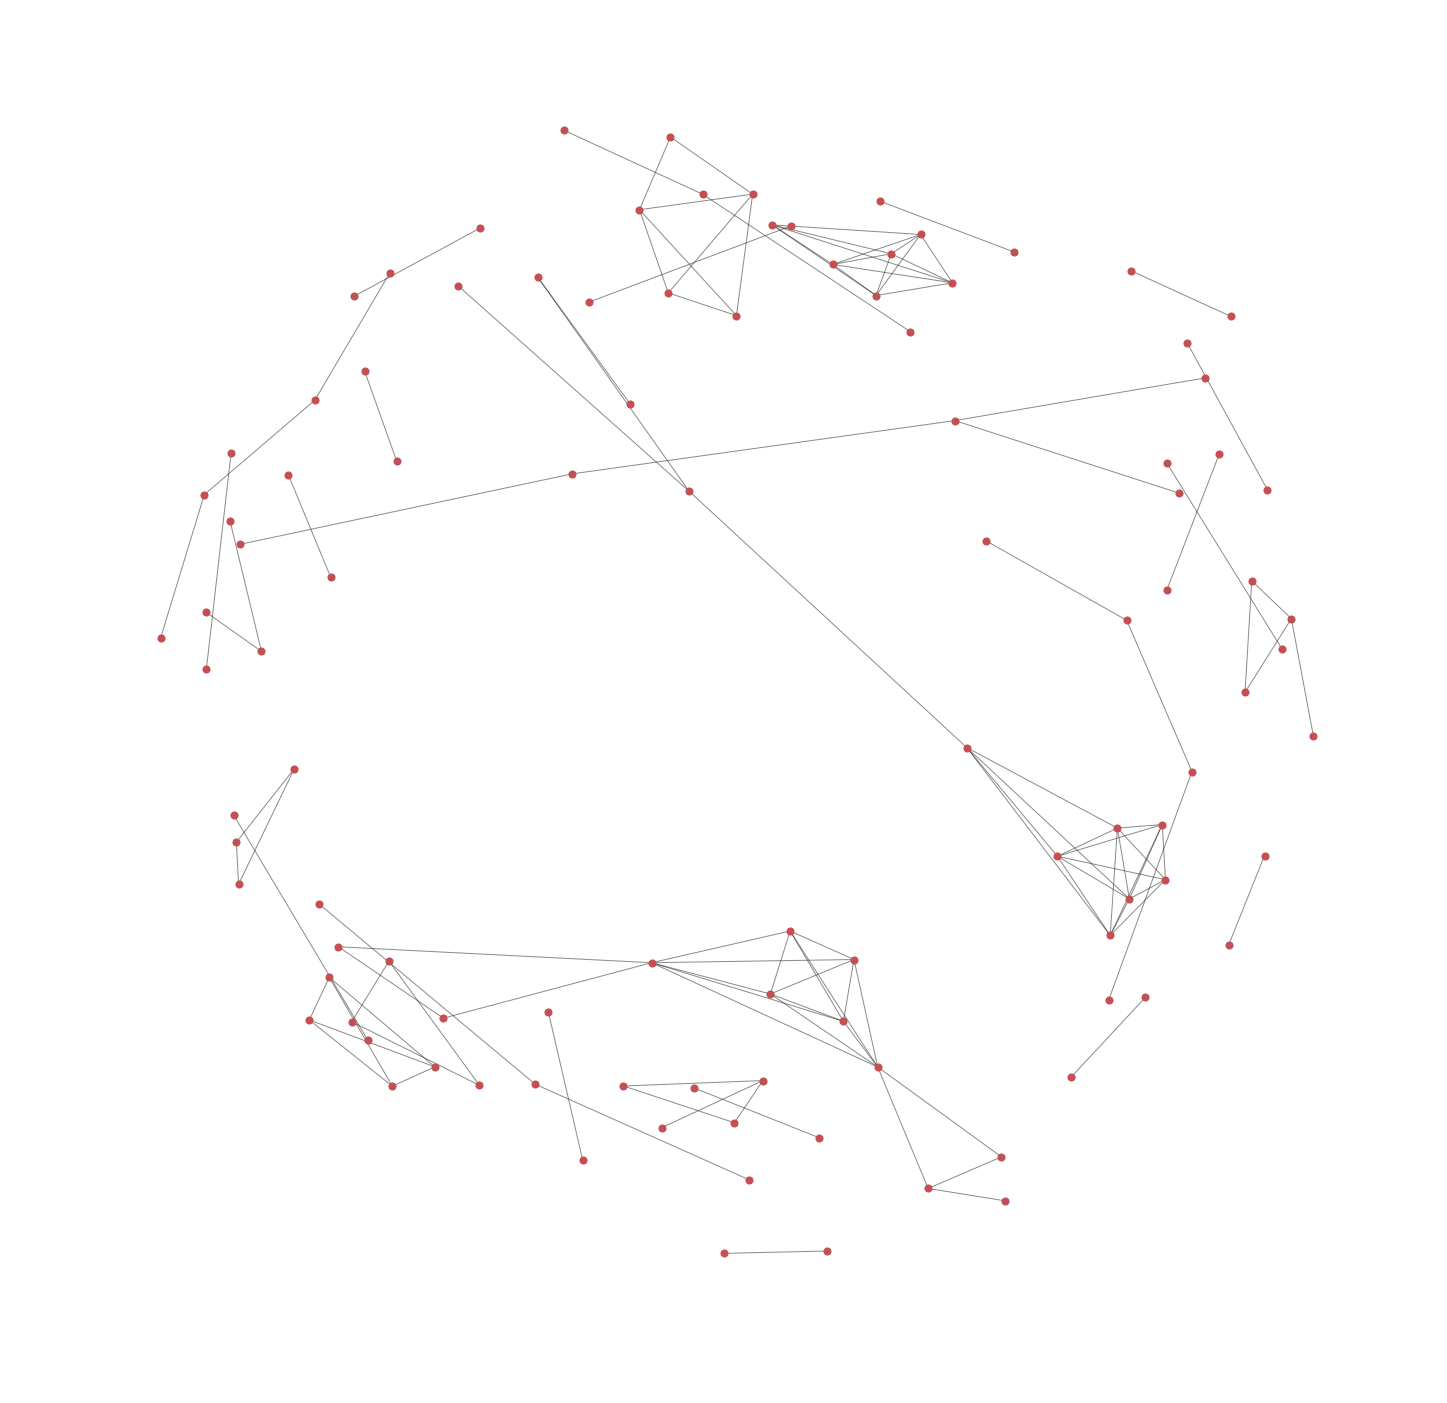

In [31]:
# remove the hosts with no links and plot the remaining ones
B.remove_nodes_from(components_one)

pos = nx.spring_layout(B,iterations=16)
labels = {node: labels_dict[node] for node in B.nodes()}

plt.figure(figsize=(25,25))
# nx.draw_networkx(B, pos, with_labels=False, node_size=100)
nx.draw_networkx_nodes(B, pos, node_size=50)
nx.draw_networkx_edges(B, pos, width=1,alpha=0.5)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=12, font_family="sans-serif")
plt.axis("off")
plt.show()